# Class definition

In [1]:
import os
from pypdf import PdfReader
import fitz
import pandas as pd
import re
from abc import ABC, abstractmethod
import time
import json

In [2]:
class PageIdentifier(ABC):
    def __init__(self, base_dir, result_dir, verbose=False):
        self.base_dir = base_dir
        self.result_dir = result_dir
        self.verbose = verbose
        self.pages = {
            "Aktiva": [],
            "Passiva": [],
            "GuV": []
        }
        self.runtime = 0
        
    def walk_dir(self):
        start_time = time.time()

        for root, _, files in os.walk(self.base_dir):
            for file in files:
                if file.endswith(".pdf"):
                    filepath = os.path.join(root, file)
                    if self.verbose:
                        print(filepath)
                    
                    try:
                        self.identify_pages(filepath)
                    except Exception as e:
                        print(f"Error reading {filepath}: {e}")

        end_time = time.time()
        self.runtime = end_time - start_time

    def __generate_dataframe(self):
        df_list = []
        for item in self.pages.keys():
            df = pd.DataFrame.from_records(self.pages[item], columns=['filepath', 'page'])
            df['type'] = item
            df_list.append(df)

        df = pd.concat(df_list, ignore_index=True)
        return(df)
    
    def __generate_benchmarking_dataframe(self, filepath_truth):
        df = self.__generate_dataframe()

        df_truth = pd.read_csv(filepath_truth)
        df_truth = df_truth.assign(type=df_truth['type'].str.split('&')).explode('type').reset_index(drop=True)

        df_common = df_truth.merge(df, on=['filepath', 'page', 'type'], how='inner')
        df_common

        df2 = df.merge(df_common[['filepath', 'page', 'type']], on=['filepath', 'page', 'type'], how='left', indicator=True)
        df2 = df2[df2['_merge'] == 'left_only'].drop(columns=['_merge'])

        df_temp = df_truth.join(
            df.set_index(['filepath', 'type']),
            on=['filepath', 'type'],
            how='left',
            rsuffix='_identified'
        )
        df_temp = df_temp[df_temp['page_identified'].isna()].drop(columns=['page_identified'])

        correct_identified = df_common
        wrong_identified = df2
        missing = df_temp

        df_list = [correct_identified, wrong_identified, missing, df_truth]
        for data in df_list:
            data['company'] = data['filepath'].str.split('/').str[2]
            data['file'] = data['filepath'].str.split('/').str[3]
            data.drop(columns=['filepath'], inplace=True)

        return df_list

    def save_to_csv(self):
        df = self.__generate_dataframe()
        df.to_csv(self.result_dir + "_identified_pages.csv", index=False)
        
    def get_dataframe(self):
        df = self.__generate_dataframe()
        return df

    def benchmark(self, verbose=True, save_to_json=True, filepath_truth="../benchmark_truth/aktiva_passiva_guv_table_pages_no_ocr.csv"):
        df_list = self.__generate_benchmarking_dataframe(filepath_truth)

        correct_identified = df_list[0]
        wrong_identified = df_list[1]
        missing = df_list[2]
        df_truth = df_list[3]
        
        if verbose:
            print(f"There are {df_truth.drop_duplicates(subset=['file', 'type', 'company', 'page']).shape[0]} unique tables.")
            print(f"Correctly identified: {len(correct_identified)}")
            print(f"Wrongly identified: {len(wrong_identified)}")
            print(f"Missing: {len(missing)}")
            print(f"Runtime: {self.runtime:.2f} seconds")

        results = {'correct': correct_identified, 'wrong': wrong_identified, 'missing': missing, 'runtime': self.runtime, 'special': [self.special_benchmark_information()]}

        if save_to_json:
            with open(f"{self.result_dir}.json", "w") as json_file:
                json.dump(
                    {key: value.to_json(orient='records') if hasattr(value, 'to_json') else value 
                    for key, value in results.items()}, 
                    json_file, 
                    indent=4, 
                    default=str
                )

        return results
        
    
    @abstractmethod
    def identify_pages(self, filepath):
        pass

    @abstractmethod
    def special_benchmark_information(self):
        pass

In [3]:
from pytesseract import image_to_string
from pdf2image import convert_from_path
from pdfminer.high_level import extract_text
from pdfminer.pdfpage import PDFPage
import pypdfium2 as pdfium
from docling_parse.pdf_parser import DoclingPdfParser, PdfDocument
from docling_core.types.doc.page import TextCellUnit
from pdfplumber import open as pdfplumber_open

class PageIdentifierRegex(PageIdentifier):
    def __init__(self, base_dir, result_dir, regex_patterns, verbose=False, ocr=False, pdfbackend='pdfium'):
        super().__init__(base_dir, result_dir, verbose)
        self.regex_patterns = regex_patterns
        self.ocr = ocr
        self.pdfbackend = pdfbackend

    def __process_text(self, text, filepath, page_num):
        if not text.strip() and self.ocr:
            # If no text is found and OCR is enabled, perform OCR
            if self.verbose:
                print(f"Performing OCR on {filepath} page {page_num + 1}")
            images = convert_from_path(filepath, first_page=page_num + 1, last_page=page_num + 1)
            if images:
                text = image_to_string(images[0])

        for item in self.pages.keys():
            if all(
                re.search(term, text, re.IGNORECASE | re.S) if isinstance(term, str) else False
                for term in self.regex_patterns[item]
            ):
                self.pages[item].append((filepath, page_num + 1))
                if self.verbose:
                    print(f"Found {item} in {filepath} on page {page_num + 1}")
            
    def special_benchmark_information(self):
        return json.dumps(self.regex_patterns)

    def identify_pages(self, filepath):
        if self.pdfbackend == 'pypdf':
            reader = PdfReader(filepath)
            for page_num, page in enumerate(reader.pages):
                text = page.extract_text()
                self.__process_text(text, filepath, page_num)

        elif self.pdfbackend == 'pymupdf':
            doc = fitz.open(filepath)
            for page_num, page in enumerate(doc):
                text = page.get_text()
                self.__process_text(text, filepath, page_num)

        elif self.pdfbackend == 'pdfminer':
            with open(filepath, 'rb') as file:
                for page_num, page in enumerate(PDFPage.get_pages(file)):
                    text = extract_text(file, page_numbers=[page_num])
                    self.__process_text(text, filepath, page_num)

        elif self.pdfbackend == 'pdfium':
            pdf = pdfium.PdfDocument(filepath)
            for page_num in range(len(pdf)):
                page = pdf[page_num]
                text = page.get_textpage().get_text_range()
                self.__process_text(text, filepath, page_num)

        elif self.pdfbackend == 'docling-parse':
            parser = DoclingPdfParser()
            pdf_doc: PdfDocument = parser.load(
                path_or_stream=filepath
            )

            # PdfDocument.iterate_pages() will automatically populate pages as they are yielded.
            for page_num, pred_page in pdf_doc.iterate_pages():
                text = '\n'.join([line.text for line in pred_page.iterate_cells(unit_type=TextCellUnit.LINE)])
                self.__process_text(text, filepath, page_num-1)

        elif self.pdfbackend == 'pdfplumber':
            with pdfplumber_open(filepath) as pdf:
                for page_num, page in enumerate(pdf.pages):
                    text = page.extract_text()
                    self.__process_text(text, filepath, page_num)

        else:
            raise ValueError(f"Unknown pdfbackend: {self.pdfbackend}")

            


# Benchmarking

## Simple Rexeg OCR

In [ ]:
simple_regex_patterns = {
    "Aktiva": [
        r"aktiva",
        r"((20\d{2}).*(20\d{2}))"
    ],
    "Passiva": [
        r"passiva",
        r"((20\d{2}).*(20\d{2}))"
    ],
    "GuV": [
        r"gewinn",
        r"verlust",
        r"rechnung",
        r"((20\d{2}).*(20\d{2}))"
    ]
}

page_identifier_regex_dummy = PageIdentifierRegex(
    base_dir = "../Geschaeftsberichte/degewo AG/",
    # base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/regex_1",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    ocr = True
)

# page_identifier_regex_dummy.walk_dir()

Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 1
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 2
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 3
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 4
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 5
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 6
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 7
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 8
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 9
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 10
Performing OCR on ../Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf page 11
Performing OCR on .

In [ ]:
ben_df_dummy = page_identifier_regex_dummy.benchmark()
ben_df_dummy['missing'][ben_df_dummy['missing']['company'] == 'degewo AG']

Correctly identified: 12
Wrongly identified: 48
Missing: 249


,page,type,page_identified,company,file
202,28,Aktiva,NaN,degewo AG,201231_degewo_Konzernlagebericht_Konzernabschl...
203,29,Passiva,NaN,degewo AG,201231_degewo_Konzernlagebericht_Konzernabschl...


In [188]:
images = convert_from_path("../Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf", first_page=27 + 1, last_page=27 + 1)
if images:
    text = image_to_string(images[0])

text
re.search(r"((20\d{2}).*(20\d{2}))", text, re.IGNORECASE | re.S)

<re.Match object; span=(65, 1938), match='2020\n\nAKTIVA\n\nA. Anlagevermégen\nI. Immaterie>

## Simple Regex

In [5]:
simple_regex_patterns = {
    "Aktiva": [
        r"aktiva",
        r"((20\d{2}).*(20\d{2}))"
    ],
    "Passiva": [
        r"passiva",
        r"((20\d{2}).*(20\d{2}))"
    ],
    "GuV": [
        r"gewinn",
        r"verlust",
        r"rechnung",
        r"((20\d{2}).*(20\d{2}))"
    ]
}

In [ ]:
page_identifier_regex_1_pypdf = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pypdf_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='pypdf'
)

page_identifier_regex_1_pypdf.walk_dir()

In [252]:
ben_df1_pypdf = page_identifier_regex_1_pypdf.benchmark()
# ben_df1_pypdf['missing']

There are 249 unique tables.
Correctly identified: 203
Wrongly identified: 595
Missing: 14
Runtime: 277.23 seconds


In [253]:
page_identifier_regex_1_pymupdf = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pymupdf_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='pymupdf'
)

page_identifier_regex_1_pymupdf.walk_dir()

In [254]:
ben_df1_pymupdf = page_identifier_regex_1_pymupdf.benchmark()

There are 249 unique tables.
Correctly identified: 207
Wrongly identified: 643
Missing: 10
Runtime: 23.48 seconds


In [255]:
page_identifier_regex_1_pdfminer = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfminer_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='pdfminer'
)

page_identifier_regex_1_pdfminer.walk_dir()

The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extractio

In [256]:
ben_df1_pdfminer = page_identifier_regex_1_pdfminer.benchmark()

There are 249 unique tables.
Correctly identified: 201
Wrongly identified: 648
Missing: 15
Runtime: 807.15 seconds


In [6]:

page_identifier_regex_1_pdfium = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfium_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='pdfium'
)

page_identifier_regex_1_pdfium.walk_dir()

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


In [7]:
ben_df1_pdfium = page_identifier_regex_1_pdfium.benchmark()

There are 249 unique tables.
Correctly identified: 202
Wrongly identified: 649
Missing: 12
Runtime: 12.42 seconds


In [29]:
page_identifier_regex_1_docling = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/docling_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='docling-parse'
)

page_identifier_regex_1_docling.walk_dir()

In [30]:
ben_df1_docling = page_identifier_regex_1_docling.benchmark()

There are 249 unique tables.
Correctly identified: 206
Wrongly identified: 640
Missing: 12
Runtime: 1518.22 seconds


In [25]:
page_identifier_regex_1_pdfplumber = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfplumber_simple_regex",
    regex_patterns = simple_regex_patterns,
    verbose = False,
    pdfbackend='pdfplumber'
)

page_identifier_regex_1_pdfplumber.walk_dir()

In [26]:
ben_df1_pdfplumber = page_identifier_regex_1_pdfplumber.benchmark()

There are 249 unique tables.
Correctly identified: 203
Wrongly identified: 644
Missing: 13
Runtime: 635.60 seconds


## Expended Regex

In [171]:
regex_patterns_2 = {
    "Aktiva": [
        r"aktiva|aktivseite|a k t i v a|a k t i v s e i t e",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "Passiva": [
        r"passiva|passivseite|p a s s i v a|p a s s i v s e i t e",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "GuV": [
        r"gewinn",
        r"verlust",
        r"rechnung",
        r"((20\d{2}).*(20\d{2}))|vorjahr"
    ]
}

page_identifier_regex_2 = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/regex_2",
    regex_patterns = regex_patterns_2,
    verbose = False
)

page_identifier_regex_2.walk_dir()

In [ ]:
ben_df2 = page_identifier_regex_2.benchmark()
ben_df2['missing']

Correctly identified: 235
Wrongly identified: 805
Missing: 12


,page,type,page_identified,company,file
178,26,Aktiva,NaN,Amt für Statistik Berlin-Brandenburg,AP_Geschaeftsbericht_DE_2009_BBB.pdf
179,27,Passiva,NaN,Amt für Statistik Berlin-Brandenburg,AP_Geschaeftsbericht_DE_2009_BBB.pdf
185,17,Passiva,NaN,Amt für Statistik Berlin-Brandenburg,AP_Geschaeftsbericht_DE_2007_BBB.pdf
187,24,Aktiva,NaN,degewo AG,2017_degewo_degewo_Homepage.pdf
188,25,Passiva,NaN,degewo AG,2017_degewo_degewo_Homepage.pdf
189,27,GuV,NaN,degewo AG,2017_degewo_degewo_Homepage.pdf
190,26,Aktiva,NaN,degewo AG,2018_degewo_Konzernlagebericht_und_Konzernabsc...
191,27,Passiva,NaN,degewo AG,2018_degewo_Konzernlagebericht_und_Konzernabsc...
192,29,GuV,NaN,degewo AG,2018_degewo_Konzernlagebericht_und_Konzernabsc...
193,26,Aktiva,NaN,degewo AG,2019_degewo_Konzernbericht_und_Gleicher_Lohn_f...


## Exhaustive Regex

In [16]:
# Aktiva und Passiva in einigen AfStatBBB nicht korrekt formatiert
regex_patterns_3 = {
    "Aktiva": [
        r"a\s*k\s*t\s*i\s*v\s*a|a\s*k\s*t\s*i\s*v\s*s\s*e\s*i\s*t\s*e|anlageverm.{1,2}gen",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "Passiva": [
        r"p\s*a\s*s\s*s\s*i\s*v\s*a|p\s*a\s*s\s*s\s*i\s*v\s*s\s*e\s*i\s*t\s*e|eigenkapital",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "GuV": [
        r"gewinn|guv",
        r"verlust|guv",
        r"rechnung|guv",
        r"((20\d{2}).*(20\d{2}))|vorjahr"
    ]
}

In [ ]:
page_identifier_regex_3_pymupdf = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pymupdf_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='pymupdf'
)

page_identifier_regex_3_pymupdf.walk_dir()

In [260]:
ben_df3_pymupdf = page_identifier_regex_3_pymupdf.benchmark()
ben_df3_pymupdf['missing']

There are 249 unique tables.
Correctly identified: 248
Wrongly identified: 1532
Missing: 0
Runtime: 22.32 seconds


,filepath,page,type,company,file


In [261]:
page_identifier_regex_3_pypdf = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pypdf_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='pypdf'
)

page_identifier_regex_3_pypdf.walk_dir()

In [262]:
ben_df3_pypdf = page_identifier_regex_3_pypdf.benchmark()
# ben_df3_pypdf['missing']

There are 249 unique tables.
Correctly identified: 246
Wrongly identified: 1469
Missing: 0
Runtime: 256.05 seconds


In [263]:
page_identifier_regex_3_pdfminer = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfminer_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='pdfminer'
)

page_identifier_regex_3_pdfminer.walk_dir()

The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2014.pdf'> contains a metadata field indicating that it should not allow text extractio

In [264]:
ben_df3_pdfminer = page_identifier_regex_3_pdfminer.benchmark()

There are 249 unique tables.
Correctly identified: 241
Wrongly identified: 1521
Missing: 0
Runtime: 797.80 seconds


In [89]:

page_identifier_regex_3_pdfium = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfium_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='pdfium'
)

page_identifier_regex_3_pdfium.walk_dir()

In [90]:
ben_df3_pdfium = page_identifier_regex_3_pdfium.benchmark()

There are 249 unique tables.
Correctly identified: 247
Wrongly identified: 1495
Missing: 0
Runtime: 14.60 seconds


In [31]:
page_identifier_regex_3_docling = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/docling_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='docling-parse'
)

page_identifier_regex_3_docling.walk_dir()

In [32]:
ben_df3_docling = page_identifier_regex_3_docling.benchmark()

There are 249 unique tables.
Correctly identified: 247
Wrongly identified: 1486
Missing: 0
Runtime: 1476.34 seconds


In [27]:
page_identifier_regex_3_pdfplumber = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfplumber_exhaustive_regex",
    regex_patterns = regex_patterns_3,
    verbose = False,
    pdfbackend='pdfplumber'
)

page_identifier_regex_3_pdfplumber.walk_dir()

In [28]:
ben_df3_pdfplumber = page_identifier_regex_3_pdfplumber.benchmark()

There are 249 unique tables.
Correctly identified: 242
Wrongly identified: 1524
Missing: 0
Runtime: 627.78 seconds


Findet nun alles, was kein OCR braucht, aber dafür auch doppelt so viel irrelevantes.

In [221]:
ben_df3['wrong'].groupby(['type', 'company']).agg(
    count=('page', 'count')
).sort_values('count', ascending=False)

count
type    company                                    
Passiva Berlinovo                               225
Aktiva  GESOBAU AG                              172
Passiva IBB                                     148
Aktiva  IBB                                     139
        Berlinovo                               129
        Berliner Bäder Betriebe                 117
GuV     Berlinovo                               105
Passiva GESOBAU AG                              105
GuV     Berliner Bäder Betriebe                  94
Passiva Berliner Bäder Betriebe                  83
GuV     IBB                                      80
        GESOBAU AG                               65
        Berlin Energie und Netzholding           40
        Amt für Statistik Berlin-Brandenburg     35
Aktiva  Berlin Energie und Netzholding           31
Passiva Berlin Energie und Netzholding           31
Aktiva  Amt für Statistik Berlin-Brandenburg     13
Passiva Amt für Statistik Berlin-Brandenburg      8
GuV     degewo AG                                 7
Passiva degewo AG                                 7
Aktiva  degewo AG                                 6

In [310]:
# still not correct identified tables
ben_df3['wrong'].drop(columns=['page_identified']).drop_duplicates().merge(
    ben_df3['correct'].drop(columns=['page_identified']).drop_duplicates(),
    on=['page', 'type', 'company', 'file'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge']).merge(
    ben_df3['missing'].drop(columns=['page_identified']).drop_duplicates(),
    on=['page', 'type', 'company', 'file'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

,page,type,company,file
0,17,GuV,IBB,ibb_digitaler_geschaeftsbericht_2017.pdf
1,71,GuV,IBB,ibb_geschaeftsbericht_2006.pdf
2,24,Aktiva,degewo AG,degewo_Konzernlagebericht_Konzernabschluss_202...
3,25,Passiva,degewo AG,degewo_Konzernlagebericht_Konzernabschluss_202...
4,27,GuV,degewo AG,degewo_Konzernlagebericht_Konzernabschluss_202...
5,28,Aktiva,degewo AG,201231_degewo_Konzernlagebericht_Konzernabschl...
6,29,Passiva,degewo AG,201231_degewo_Konzernlagebericht_Konzernabschl...
7,31,GuV,degewo AG,201231_degewo_Konzernlagebericht_Konzernabschl...
8,43,GuV,Berlin Energie und Netzholding,SIGNATURE_DEE00084236.1.1_550912_Endexemplar_2...


## Exhaustive Regex OCR

In [ ]:
regex_patterns_3 = {
    "Aktiva": [
        r"aktiva|aktivseite|a k t i v a|a k t i v s e i t e|anlageverm.{1,2}gen",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "Passiva": [
        r"passiva|passivseite|p a s s i v a|p a s s i v s e i t e|eigenkapital",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr"
    ],
    "GuV": [
        r"gewinn",
        r"verlust",
        r"rechnung",
        r"((20\d{2}).*(20\d{2}))|vorjahr"
    ]
}

page_identifier_regex_3_ocr = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/regex_3",
    regex_patterns = regex_patterns_3,
    verbose = True,
    ocr = True
)

# page_identifier_regex_3_ocr.walk_dir()

In [ ]:
ben_df3_ocr = page_identifier_regex_3_ocr.benchmark()
ben_df3_ocr['missing']

## Exhaustive Regex restricting

In [ ]:
# Aktiva und Passiva in einigen AfStatBBB nicht korrekt formatiert
regex_patterns_4 = {
    "Aktiva": [
        r"a\s*k\s*t\s*i\s*v\s*a|a\s*k\s*t\s*i\s*v\s*s\s*e\s*i\s*t\s*e|anlageverm.{1,2}gen",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr",
        r"anlageverm.{1,2}gen"
    ],
    "Passiva": [
        r"p\s*a\s*s\s*s\s*i\s*v\s*a|p\s*a\s*s\s*s\s*i\s*v\s*s\s*e\s*i\s*t\s*e|eigenkapital",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr",
        r"eigenkapital"
    ],
    "GuV": [
        r"gewinn|guv",
        r"verlust|guv",
        r"rechnung|guv",
        r"((20\d{2}).*(20\d{2}))|vorjahr"
    ]
}

page_identifier_regex_4 = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/regex_3",
    regex_patterns = regex_patterns_4,
    verbose = False
)

page_identifier_regex_4.walk_dir()

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


Mehrseitige GuV in "ibb_geschaeftsbericht_2017.pdf"

In [39]:
ben_df4 = page_identifier_regex_4.benchmark(save_to_json=False)
ben_df4['missing']

There are 249 unique tables.
Correctly identified: 215
Wrongly identified: 1297
Missing: 0
Runtime: 12.66 seconds


,page,type,company,file


In [50]:
ben_df3_pdfium = page_identifier_regex_3_pdfium.benchmark()

There are 249 unique tables.
Correctly identified: 247
Wrongly identified: 1495
Missing: 0
Runtime: 12.92 seconds


In [91]:
# Aktiva und Passiva in einigen AfStatBBB nicht korrekt formatiert
regex_patterns_5 = {
    "Aktiva": [
        r"a\s*k\s*t\s*i\s*v\s*a|a\s*k\s*t\s*i\s*v\s*s\s*e\s*i\s*t\s*e|anlageverm.{1,2}gen",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr",
        r"Umlaufverm.{1,2}gen|Anlageverm.{1,2}gen|Rechnungsabgrenzungsposten|Forderungen",
        r"\s([a-zA-Z]|[0-9]{1,2}|[iI]+)[\.\)]\s"
    ],
    "Passiva": [
        r"p\s*a\s*s\s*s\s*i\s*v\s*a|p\s*a\s*s\s*s\s*i\s*v\s*s\s*e\s*i\s*t\s*e|eigenkapital",
        r"((20\d{2}).*(20\d{2}))|((20\d{2}).*vorjahr)|vorjahr",
        r"Eigenkapital|R.{1,2}ckstellungen|Verbindlichkeiten|Rechnungsabgrenzungsposten",
        r"\s([a-zA-Z]|[0-9]{1,2}|[iI]+)[\.\)]\s"
    ],
    "GuV": [
        r"gewinn|guv",
        r"verlust|guv",
        r"rechnung|guv",
        r"((20\d{2}).*(20\d{2}))|vorjahr"
        r"Umsatzerl.{1,2}se|Materialaufwand|Personalaufwand|Abschreibungen|Jahres.{1,2}berschuss|Jahresfehlbetrag|Steuern|Vertriebskosten|Verwaltungskosten|Aufwendungen|Ertr.{1,2}ge",
        r"\s([a-zA-Z]|[0-9]{1,2}|[iI]+)[\.\)]\s"
    ]
}

page_identifier_regex_5 = PageIdentifierRegex(
    # base_dir = "../Geschaeftsberichte/Berlin Energie und Netzholding/",
    base_dir = "../Geschaeftsberichte/",
    result_dir= "../benchmark_results/page_identification/pdfium_exhaustive_regex_restricted",
    regex_patterns = regex_patterns_5,
    verbose = False
)

page_identifier_regex_5.walk_dir()

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


In [92]:
ben_df5 = page_identifier_regex_5.benchmark(save_to_json=True)

ben_df3_pdfium['correct'].merge(
    ben_df5['correct'],
    on=['page', 'type', 'company', 'file'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

There are 249 unique tables.
Correctly identified: 244
Wrongly identified: 1018
Missing: 0
Runtime: 24.29 seconds


,page,type,company,file
199,42,Aktiva,Berlin Energie und Netzholding,Jahresabschluss-BEN-GmbH-2023.pdf
200,42,Passiva,Berlin Energie und Netzholding,Jahresabschluss-BEN-GmbH-2023.pdf
205,42,Aktiva,Berlin Energie und Netzholding,SIGNATURE_DEE00084236.1.1_550912_Endexemplar_2...
206,42,Passiva,Berlin Energie und Netzholding,SIGNATURE_DEE00084236.1.1_550912_Endexemplar_2...


# Tests

## Extracting text

In [93]:
text = PdfReader('../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2006.pdf').pages[67].extract_text()
text

'\x18\x18\nJahresbilanz zum 31. Dezember 2006\na ktivseite in te U r\n31.12.2006 31.12.2005\n1. Barreserve\n\t\n\t\nb)\t\n\t\nGuthaben\n\t\nbei\n\t\nZentralnotenbanken\t\ndarunter:\n\t\nbei\n\t\nder\n\t\nDeutschen\n\t\nBundesbank:\t\nTEUR\n\t\n19.823\n\t\n(31.12.2005\n\t\n:\n\t\nTEUR\n\t\n28.873)\n3. Forderungen an \nk\nreditinstitute\n\t a)\n\t\ntäglich\n\t\nfällig\n\t b)\n\t\nandere\n\t\nForderungen\n4. Forderungen an \nk\nunden\n\t\n\t\ndarunter:\n\t\t\ndurch\n\t\nGrundpfandrechte\n\t\ngesichert:\t\nTEUR\n\t\n9.496.661\n\t\n(31.12.2005\n\t\n:\n\t\nTEUR\n\t\n10.660.277)\t\nKommunalkredite:\n\t\nTEUR\n\t\n3.532.796\n\t\n(31.12.2005\n\t\n:\n\t\nTEUR\n\t\n2.338.961)\n5. Schuldverschreibungen und andere festverzinsliche Wertpapiere\n\t a)\n\t\n\tGeldmarktpapiere\n\t\n\t\t ab)\n\t\nvon\n\t\nanderen\n\t\nEmittenten\t\n\t b)\n\t\n\tAnleihen\n\t\nund\n\t\nSchuldverschreibungen\n\t\n\t\t ba)\n\t\nvon\n\t\nöffentlichen\n\t\nEmittenten\n\t\n\t\t darunter:\n\t\nbeleihbar\n\t\nbei\n\t\nder\n\t\nD

In [94]:
re.search(r"a\sktiva", text, re.IGNORECASE | re.S)

<re.Match object; span=(1380, 1387), match='a\nktiva'>

## OCR

In [95]:
file_list = []
for root, _, files in os.walk("../Geschaeftsberichte/"):
    for file in files:
        file_list.append(os.path.join(root, file))

file_list

missing_files = [file for file in file_list if file not in df_truth['filepath'].values]
missing_files

NameError: name 'df_truth' is not defined

The is no table of interest in  "../Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzernabschluss-2023.pdf"

In [ ]:
df_truth = pd.read_csv("../benchmark_truth/aktiva_passiva_guv_table_pages.csv")
df_truth = df_truth.assign(type=df_truth['type'].str.split('&')).explode('type')
df_truth.shape[0]

265

## Table detection

In [60]:
df_correct_tables = pd.read_csv("../benchmark_truth/aktiva_passiva_guv_table_pages.csv")
df_correct_tables['table'] = 1
df_wrong_tables = pd.read_csv("../benchmark_truth/tables_on_wrong_identified_pages_simple_regex.csv")
df_wrong_tables['filepath'] = "../Geschaeftsberichte/"+df_wrong_tables['company']+"/"+df_wrong_tables['file']
df_wrong_tables.drop(columns=['company', 'file'], inplace=True)
df_wrong_tables.rename(columns={'page_identfied': 'page'}, inplace=True)
df_wrong_tables = df_wrong_tables.merge(df_correct_tables[['filepath', 'page',]], on=['filepath', 'page'], how='left', indicator=True)
df_wrong_tables = df_wrong_tables[df_wrong_tables['_merge'] == 'left_only'].drop(columns=['_merge'])
df_wrong_tables['target'] = 0
df_correct_tables['target'] = 1

df_table_detection_benchmark = pd.concat([df_correct_tables, df_wrong_tables])
df_table_detection_benchmark.drop(columns=['type'], inplace=True)
df_table_detection_benchmark.drop_duplicates(inplace=True)
df_table_detection_benchmark.to_csv("../benchmark_truth/table_detection.csv")
# df_table_detection_benchmark

In [ ]:
from transformers import pipeline
import numpy as np

def run_benchmark(model, thresholds):
    df_table_detection_benchmark = pd.read_csv("../benchmark_truth/table_detection.csv")
    df_table_detection_benchmark['score'] = pd.NA
    benchmark_results = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'recall_target', 'F1'])    

    start_time = time.time()

    if model == "yolov12l-doclaynet":
        pass

    if model == "microsoft/table-transformer-detection":
        pipe = pipeline("object-detection", model="microsoft/table-transformer-detection")

        df_table_detection_benchmark.copy()
        for _, row in df_table_detection_benchmark.iterrows():
            filepath = row['filepath']
            page_num = int(row['page'])

            images = convert_from_path(filepath, first_page=page_num, last_page=page_num)
            if len(images) > 0:
                # print(f"{filepath} page {page_num}")
                results = pipe(images[0], threshold=0)

                if len(results) > 0:
                    score = max(result['score'] for result in results)
                    df_table_detection_benchmark.loc[_, 'score'] = score
                    # print(score)
                else:
                    df_table_detection_benchmark.loc[_, 'score'] = 0
        
        for threshold in thresholds:
            x = df_table_detection_benchmark.copy()
            x['prediction'] = np.where(x['score'] > threshold, 1, 0)

            true_positive = x[(x['table'] == 1) & (x['prediction'] == 1)].shape[0]
            false_positive = x[(x['table'] == 0) & (x['prediction'] == 1)].shape[0]
            # true_negative = x[(x['table'] == 0) & (x['prediction'] == 0)].shape[0]
            false_negative = x[(x['table'] == 1) & (x['prediction'] == 0)].shape[0]

            y = x[x['target'] == 1]

            true_positive_target = y[(y['table'] == 1) & (y['prediction'] == 1)].shape[0]
            false_negative_target = y[(y['table'] == 1) & (y['prediction'] == 0)].shape[0]

            precision = round(true_positive/(true_positive+false_positive),2) if (true_positive+false_positive) > 0 else pd.NA
            recall = round(true_positive/(true_positive+false_negative),2) if (true_positive+false_negative) > 0 else pd.NA
            recall_target = round(true_positive_target/(true_positive_target+false_negative_target),2) if (true_positive_target+false_negative_target) > 0 else pd.NA
            F1 = round(2*precision*recall/(precision+recall),2) if (precision is not pd.NA and recall is not pd.NA and (precision+recall) > 0) else pd.NA

            benchmark_results = pd.concat([benchmark_results, pd.DataFrame([{'threshold': threshold, 'precision': precision, 'recall': recall, 'recall_target': recall_target, 'F1': F1}])], ignore_index=True)
            
    end_time = time.time()
    runtime = end_time - start_time
    print(runtime)

    return  benchmark_results
 
# x = run_benchmark("microsoft/table-transformer-detection", [*[x/100.0 for x in range(50,95,10)],0.95,0.98])
y = run_benchmark("microsoft/table-transformer-detection", [x/100.0 for x in range(0,100,1)])

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter 

295.0076394081116


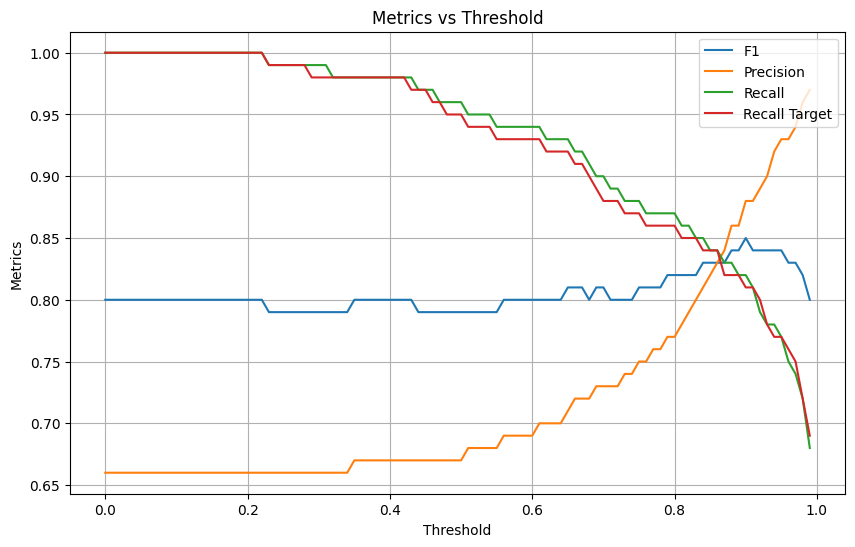

In [92]:
import matplotlib.pyplot as plt

# Plot the metrics over the threshold
plt.figure(figsize=(10, 6))
plt.plot(y['threshold'], y['F1'], label='F1', marker='')
plt.plot(y['threshold'], y['precision'], label='Precision', marker='')
plt.plot(y['threshold'], y['recall'], label='Recall', marker='')
plt.plot(y['threshold'], y['recall_target'], label='Recall Target', marker='')

# Add labels, title, and legend
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### test code

In [141]:
from ultralytics import YOLO

model = YOLO("../models/YOLO/yolov12l-doclaynet.pt")
images = convert_from_path("../benchmark_results/page_identification/ben_df1_wrong_pages.pdf", first_page=0, last_page=10)
image = images[4]

# image = convert_from_path("../benchmark_tables/easy_table_german_finance_v2.pdf")[0]
pred = model(image)
#print(pred)


0: 1024x736 1 Page-footer, 7 Section-headers, 1 Table, 7 Texts, 1105.7ms
Speed: 6.3ms preprocess, 1105.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)


In [142]:
from ultralytics.utils.plotting import Annotator
from PIL import Image

for r in pred:
    annotator = Annotator(image)
        
    boxes = r.boxes
    for box in boxes:
        
        b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    
    img = annotator.result()
    # Convert the numpy array to a PIL Image and display it
    Image.fromarray(img).show()


Opening in existing browser session.


In [143]:
pred[0].names
for p in pred:
    for b in p.boxes:
        print(f"{p.names[int(b.cls)]}: {b.conf}")

Text: tensor([0.9731])
Text: tensor([0.9726])
Text: tensor([0.9704])
Text: tensor([0.9699])
Table: tensor([0.9589])
Text: tensor([0.9508])
Section-header: tensor([0.8850])
Text: tensor([0.8797])
Section-header: tensor([0.8796])
Section-header: tensor([0.8741])
Section-header: tensor([0.8735])
Section-header: tensor([0.8655])
Section-header: tensor([0.8447])
Text: tensor([0.8422])
Page-footer: tensor([0.8143])
Section-header: tensor([0.7963])


In [101]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/table-detection-and-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# set image
image = 'http://images.cocodataset.org/val2017/000000039769.jpg'

# perform inference
results = model.predict(image)

# observe results
print(results[0].boxes)
#render = render_result(model=model, image=image, result=results[0])
#render.show()

ImportError: cannot import name 'yaml_save' from 'ultralytics.utils' (/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/ultralytics/utils/__init__.py)

In [8]:
from transformers import pipeline
from PIL import ImageDraw, ImageFont
# import warnings

font = ImageFont.truetype(font="/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", size = 20)
threshold = 0.95 # 48 Tabellen wurden nicht erkannt
threshold = 0.90 # 38 Tabellen wurden nicht erkannt
threshold = 0.70 # 22 Tabellen wurden nicht erkannt
threshold = 0.50 # 10 Tabellen wurden nicht erkannt

# warnings.filterwarnings("ignore")
pipe = pipeline("object-detection", model="microsoft/table-transformer-detection")

counter = {'with_table': 0, 'without_table': 0}

for _, row in ben_df1_pdfium['correct'].iterrows():
    filepath = f"../Geschaeftsberichte/{row['company']}/{row['file']}"
    page_num = row['page']

    images = convert_from_path(filepath, first_page=page_num, last_page=page_num)
    results = pipe(images[0], threshold=threshold)

    if len(results) > 0:
        counter['with_table'] += 1
    else:
        counter['without_table'] += 1
        draw = ImageDraw.Draw(images[0])
        draw.text((10, 10), f"{filepath} at page: {page_num}", fill="red", font=font)
        images[0].show()

print(counter)

/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/simon/anaconda3/envs/llm/lib/python3.13/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter 

Opening in existing browser session.


Created TensorFlow Lite XNNPACK delegate for CPU.
Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors (tensor#-1 is a dynamic-sized tensor).


Opening in existing browser session.


[133331:133331:0511/110957.959085:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 1 times!
[133331:133331:0511/111001.973253:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 2 times!
[133331:133331:0511/111005.845878:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 3 times!


Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
{'with_table': 192, 'without_table': 10}


In [ ]:
# ben_df1['wrong'].drop(columns=['page', 'type']).drop_duplicates().to_csv("../benchmark_results/page_identification/ben_df1_wrong.csv", index=False)

df_temp = ben_df1['wrong'].drop(columns=['page', 'type']).drop_duplicates()
df_temp['filepath'] = '../Geschaeftsberichte/' + df_temp['company'] + "/" + df_temp['file']

from pypdf import PdfWriter

writer = PdfWriter()
for _, row in df_temp.iterrows():
    filepath = row['filepath']
    page_num = int(row['page_identified']) - 1  # Page numbers are 0-indexed in PdfReader

    reader = PdfReader(filepath)
    writer.add_page(reader.pages[page_num])

with open("../benchmark_results/page_identification/ben_df1_wrong_pages.pdf", "wb") as output_pdf:
    writer.write(output_pdf)

In [ ]:
# ben_df1['wrong'].drop(columns=['page', 'type']).drop_duplicates().to_csv("../benchmark_results/page_identification/ben_df1_wrong.csv", index=False)

df_temp = ben_df1['correct'].drop(columns=['page', 'type']).drop_duplicates()
df_temp['filepath'] = '../Geschaeftsberichte/' + df_temp['company'] + "/" + df_temp['file']

from pypdf import PdfWriter

writer = PdfWriter()
for _, row in df_temp.iterrows():
    filepath = row['filepath']
    page_num = int(row['page_identified']) - 1  # Page numbers are 0-indexed in PdfReader

    reader = PdfReader(filepath)
    writer.add_page(reader.pages[page_num])

with open("../benchmark_results/page_identification/ben_df1_correct_pages.pdf", "wb") as output_pdf:
    writer.write(output_pdf)

In [ ]:
from transformers import pipeline
from PIL import ImageDraw
# import warnings

threshold = 0.95 #  Tabellen wurden nicht erkannt

# warnings.filterwarnings("ignore")
pipe = pipeline("object-detection", model="microsoft/table-transformer-detection")

counter = {'with_table': 0, 'without_table': 0}

verbose = True

for _, row in ben_df1['wrong'].iterrows():
    filepath = f"../Geschaeftsberichte/{row['company']}/{row['file']}"
    page_num = int(row['page_identified'])

    images = convert_from_path(filepath, first_page=page_num, last_page=page_num)
    results = pipe(images[0], threshold=threshold)
    
    if len(results) > 0:
        counter['with_table'] += 1

        if verbose:    
            # Draw the bounding boxes on the image
            print(ben_df1['wrong'].loc[_])
            print(f"Found {len(results)} tables in {filepath} on page {page_num}")
            draw = ImageDraw.Draw(images[0])
            for result in results:
                box = result['box']
                draw.rectangle([box['xmin'], box['ymin'], box['xmax'], box['ymax']], outline="red", width=3)
                draw.text((box['xmin']+10, box['ymin']+10), f"{filepath} at page: {page_num} ({result['score']:.2f})", fill="red", font=font)

                # Show the image with the bounding boxes
                images[0].show()
    else:
        counter['without_table'] += 1

print(counter)    

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


page                                      10
type                                  Aktiva
page_identified                         22.0
company              Berliner Bäder Betriebe
file               GB_BBB_Infra_2022_low.pdf
Name: 1, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2022_low.pdf on page 22
page                                      13
type                                     GuV
page_identified                         35.0
company              Berliner Bäder Betriebe
file               GB_BBB_Infra_2022_low.pdf
Name: 6, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2022_low.pdf on page 35
Opening in existing browser session.
page                                      28
type                                  Aktiva
page_identified                         22.0
company              Berliner Bäder Betriebe
file               GB_BBB_Infra_2022_low.pdf
Name: 10, dtype: object
Found 1 tables i

[92300:92300:0509/182149.573550:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 1 times!
[92300:92300:0509/182149.583856:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 2 times!


page                                           16
type                                       Aktiva
page_identified                              11.0
company                   Berliner Bäder Betriebe
file               2023_Geschaeftsbericht_BBB.pdf
Name: 18, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/2023_Geschaeftsbericht_BBB.pdf on page 11
Opening in existing browser session.
page                                           17
type                                      Passiva
page_identified                              11.0
company                   Berliner Bäder Betriebe
file               2023_Geschaeftsbericht_BBB.pdf
Name: 19, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/2023_Geschaeftsbericht_BBB.pdf on page 11
Opening in existing browser session.
page                                           19
type                                          GuV
page_identified                              21.0
company         

Created TensorFlow Lite XNNPACK delegate for CPU.
Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors (tensor#-1 is a dynamic-sized tensor).


page                                    28
type                                Aktiva
page_identified                       22.0
company            Berliner Bäder Betriebe
file                 GB_BBB_Infra_2020.pdf
Name: 38, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2020.pdf on page 22
Opening in existing browser session.


[92300:92300:0509/182158.402465:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 3 times!


page                                    28
type                                Aktiva
page_identified                       23.0
company            Berliner Bäder Betriebe
file                 GB_BBB_Infra_2020.pdf
Name: 39, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2020.pdf on page 23
Opening in existing browser session.
page                                    29
type                               Passiva
page_identified                       22.0
company            Berliner Bäder Betriebe
file                 GB_BBB_Infra_2020.pdf
Name: 41, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2020.pdf on page 22
Opening in existing browser session.
page                                    29
type                               Passiva
page_identified                       23.0
company            Berliner Bäder Betriebe
file                 GB_BBB_Infra_2020.pdf
Name: 42, dtype: object
Found 1 tables 

[94856:94856:0100/000000.174408:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                           20
type                                       Aktiva
page_identified                              17.0
company                   Berliner Bäder Betriebe
file               2019_Geschaeftsbericht_BBB.pdf
Name: 107, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/2019_Geschaeftsbericht_BBB.pdf on page 17
Opening in existing browser session.
page                                           20
type                                       Aktiva
page_identified                              18.0
company                   Berliner Bäder Betriebe
file               2019_Geschaeftsbericht_BBB.pdf
Name: 108, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berliner Bäder Betriebe/2019_Geschaeftsbericht_BBB.pdf on page 18
Opening in existing browser session.
page                                           20
type                                      Passiva
page_identified                              17.0
company       

[95521:95521:0100/000000.207767:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                                          4
type                                                     Aktiva
page_identified                                             8.0
company                                                     IBB
file               ibb-jahresabschluss-und-lagebericht-2023.pdf
Name: 139, dtype: object
Found 1 tables in ../Geschaeftsberichte/IBB/ibb-jahresabschluss-und-lagebericht-2023.pdf on page 8
Opening in existing browser session.
page                                                          4
type                                                     Aktiva
page_identified                                            48.0
company                                                     IBB
file               ibb-jahresabschluss-und-lagebericht-2023.pdf
Name: 141, dtype: object
Found 1 tables in ../Geschaeftsberichte/IBB/ibb-jahresabschluss-und-lagebericht-2023.pdf on page 48
Opening in existing browser session.
page                                 

[97803:97803:0100/000000.548316:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                           44
type                                       Aktiva
page_identified                              36.0
company                                       IBB
file               ibb_geschaeftsbericht_2015.pdf
Name: 207, dtype: object
Found 1 tables in ../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2015.pdf on page 36
Opening in existing browser session.
page                                           44
type                                       Aktiva
page_identified                              37.0
company                                       IBB
file               ibb_geschaeftsbericht_2015.pdf
Name: 208, dtype: object
Found 2 tables in ../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2015.pdf on page 37
Opening in existing browser session.
Opening in existing browser session.
page                                           44
type                                       Aktiva
page_identified                              38.0
company          

[98825:98825:0100/000000.911985:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                                         37
type                                                        GuV
page_identified                                            48.0
company                                                     IBB
file               ibb-jahresabschluss-und-lagebericht-2024.pdf
Name: 243, dtype: object
Found 2 tables in ../Geschaeftsberichte/IBB/ibb-jahresabschluss-und-lagebericht-2024.pdf on page 48
Opening in existing browser session.
Opening in existing browser session.
page                                           68
type                                       Aktiva
page_identified                              56.0
company                                       IBB
file               ibb_geschaeftsbericht_2006.pdf
Name: 245, dtype: object
Found 1 tables in ../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2006.pdf on page 56
Opening in existing browser session.
page                                           68
type                             

[99198:99198:0100/000000.733227:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                           71
type                                          GuV
page_identified                               7.0
company                                       IBB
file               ibb_geschaeftsbericht_2006.pdf
Name: 252, dtype: object
Found 1 tables in ../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2006.pdf on page 7
Opening in existing browser session.
page                                           71
type                                          GuV
page_identified                              83.0
company                                       IBB
file               ibb_geschaeftsbericht_2006.pdf
Name: 254, dtype: object
Found 2 tables in ../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2006.pdf on page 83
Opening in existing browser session.
Opening in existing browser session.
page                                           66
type                                       Aktiva
page_identified                              45.0
company           

[103712:103712:0100/000000.324042:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                   33
type                               Aktiva
page_identified                      37.0
company                         Berlinovo
file               berlinovo_gb2019_s.pdf
Name: 404, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berlinovo/berlinovo_gb2019_s.pdf on page 37
Opening in existing browser session.
page                                             40
type                                         Aktiva
page_identified                                26.0
company                                   Berlinovo
file               berlinovo_Finanzbericht_2021.pdf
Name: 412, dtype: object
Found 1 tables in ../Geschaeftsberichte/Berlinovo/berlinovo_Finanzbericht_2021.pdf on page 26
Opening in existing browser session.
page                                             40
type                                         Aktiva
page_identified                                45.0
company                                   Berlinovo
file               b

[104569:104569:0100/000000.487841:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                                 20
type                                                GuV
page_identified                                    19.0
company            Amt für Statistik Berlin-Brandenburg
file               AP_Geschaeftsbericht_DE_2011_BBB.pdf
Name: 478, dtype: object
Found 1 tables in ../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2011_BBB.pdf on page 19
Opening in existing browser session.
page                                                 30
type                                                GuV
page_identified                                    29.0
company            Amt für Statistik Berlin-Brandenburg
file               AP_Geschaeftsbericht_DE_2018_BBB.pdf
Name: 484, dtype: object
Found 1 tables in ../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2018_BBB.pdf on page 29
Opening in existing browser session.
page                                                 26
type      

[107203:107203:0100/000000.521800:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                               52
type                                           Aktiva
page_identified                                  39.0
company                                    GESOBAU AG
file               GESOBAU_Geschaeftsbericht_2018.pdf
Name: 591, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Geschaeftsbericht_2018.pdf on page 39
Opening in existing browser session.
page                                               52
type                                           Aktiva
page_identified                                  55.0
company                                    GESOBAU AG
file               GESOBAU_Geschaeftsbericht_2018.pdf
Name: 592, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Geschaeftsbericht_2018.pdf on page 55
Opening in existing browser session.
page                                               52
type                                           Aktiva
page_identified                   

[109204:109204:0100/000000.304781:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


Opening in existing browser session.
page                                                 38
type                                            Passiva
page_identified                                    52.0
company                                      GESOBAU AG
file               GESOBAU_Geschaftsbericht_2023_bf.pdf
Name: 634, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Geschaftsbericht_2023_bf.pdf on page 52
Opening in existing browser session.
page                                                 39
type                                                GuV
page_identified                                     3.0
company                                      GESOBAU AG
file               GESOBAU_Geschaftsbericht_2023_bf.pdf
Name: 635, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Geschaftsbericht_2023_bf.pdf on page 3
Opening in existing browser session.
page                                                 39
type                      

[110947:110947:0100/000000.848148:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                                   62
type                                               Aktiva
page_identified                                      70.0
company                                        GESOBAU AG
file               GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf
Name: 685, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf on page 70
Opening in existing browser session.
page                                                   62
type                                               Aktiva
page_identified                                      91.0
company                                        GESOBAU AG
file               GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf
Name: 686, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf on page 91
Opening in existing browser session.
page                                                   63
type                                

[111155:111155:0100/000000.627147:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                                   63
type                                              Passiva
page_identified                                      91.0
company                                        GESOBAU AG
file               GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf
Name: 690, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf on page 91
Opening in existing browser session.
page                                                   64
type                                                  GuV
page_identified                                      70.0
company                                        GESOBAU AG
file               GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf
Name: 692, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch%C3%A4ftsbericht_2024.pdf on page 70
Opening in existing browser session.
page                                                   64
type                                

[112598:112598:0100/000000.201376:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


page                                               54
type                                              GuV
page_identified                                  64.0
company                                    GESOBAU AG
file               GESOBAU_Geschaeftsbericht_2017.pdf
Name: 730, dtype: object
Found 1 tables in ../Geschaeftsberichte/GESOBAU AG/GESOBAU_Geschaeftsbericht_2017.pdf on page 64
Opening in existing browser session.


[112644:112644:0100/000000.764939:ERROR:zygote_linux.cc(664)] write: Broken pipe (32)


{'with_table': 310, 'without_table': 369}
